# Задачи 5-6

Импорт модулей

In [1]:
import os
import numpy as np
from numpy import pi, sin, cos, sqrt
import datetime as dt
import matplotlib.pyplot as plt

from scipy.misc import derivative
from scipy.interpolate import interp1d
from scipy import integrate

try:
  import google.colab
  IN_COLAB = True
except:
  IN_COLAB = False

In [2]:
if IN_COLAB:
    from google.colab import drive
    drive.mount('/content/drive')

Чтение файлов

In [3]:
if IN_COLAB:
  NRLMSIS_day = np.loadtxt('/content/drive/MyDrive/exam_rrv/NRLMSIS_day.txt', skiprows=1)
  NRLMSIS_night = np.loadtxt('/content/drive/MyDrive/exam_rrv/NRLMSIS_night.txt', skiprows=1)
  IRI_day = np.loadtxt('/content/drive/MyDrive/exam_rrv/IRI2016_day.txt', skiprows=35)
  IRI_night = np.loadtxt('/content/drive/MyDrive/exam_rrv/IRI2016_night.txt', skiprows=35)
else:
  NRLMSIS_day = np.loadtxt('NRLMSIS_day.txt', skiprows=1)
  NRLMSIS_night = np.loadtxt('NRLMSIS_night.txt', skiprows=1)
  IRI_day = np.loadtxt('IRI2016_day.txt', skiprows=35)
  IRI_night = np.loadtxt('IRI2016_night.txt', skiprows=35)

Создание массивов

In [4]:
N_e_day = np.array([item[1] for item in IRI_day], dtype=np.longdouble)
N_e_night = np.array([item[1] for item in IRI_night], dtype=np.longdouble)
z = np.array([item[0] for item in IRI_day], dtype=int) * 1000

Чистка данных

In [5]:
mask_day = N_e_day != -1
mask_night = N_e_night != -1

N_e_day = N_e_day[mask_day]
N_e_night = N_e_night[mask_night]

z_day = z[mask_day]
z_night = z[mask_night]

Блок с константами

In [6]:
date = dt.datetime(int(NRLMSIS_day[0][0]), int(NRLMSIS_day[0][1]), int(NRLMSIS_day[0][2]), int(NRLMSIS_day[0][4]))

e_charge = -1.6 * 1e-19
mass_e = 9.1 * 1e-31
omega = 2 * pi * (8 * 1e6)

Блок с формулами для расчетов

In [7]:
omega_plasm_day = (4 * pi * (e_charge ** 2) * N_e_day / mass_e) * 1e6
omega_plasm_night = (4 * pi * (e_charge ** 2) * N_e_night / mass_e) * 1e6
n_day = sqrt(1 - ((omega_plasm_day ** 2)/(omega ** 2)))
n_night = sqrt(1 - ((omega_plasm_night ** 2)/(omega ** 2)))

In [8]:
interpol_n_day = interp1d(z_day, n_day, kind = 'cubic')
interpol_n_night = interp1d(z_night, n_night, kind = 'cubic')

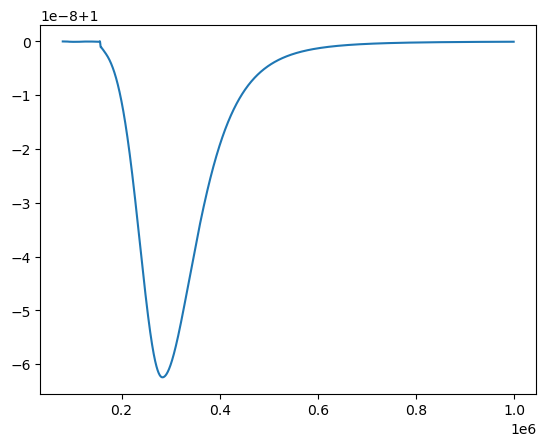

In [9]:
z_ = np.linspace(z_night[0], z_night[-1], 4096)
plt.plot(z_, interpol_n_night(z_))

# Интегрируем епта

In [10]:
from scipy.integrate import solve_ivp

dp_zdt = lambda z, n: 0.5 * derivative(lambda z: n(z)**2, z, dx=1, n=1, order=3)

def ode(t, p, n, p_x, p_y): 
    x,y,z,p_z = p
    return [p_x, p_y, p_z, dp_zdt(z, n)]

def solve(n, z0, teta_0, phi_0, t):
    p_x0 = n(z0)*np.sin(teta_0) * np.cos(phi_0)
    p_y0 = n(z0)*np.sin(teta_0) * np.sin(phi_0)
    p_z0 = n(z0)*np.cos(teta_0)
    
    print(p_x0, p_y0, p_z0)
    p0 = [0, 0, z0, p_z0]
    sol = solve_ivp(ode, [t[0], t[-1]], p0, args=(n, p_x0, p_y0),
                    dense_output=True)

    return sol.sol(t)

In [11]:
t = np.linspace(0,1000e3, 4096) # лол соответствует длинне с точнгостьб до сотки, ведь n~1
x,y,z,p_z = solve(interpol_n_night, z_night[1], 45/180*np.pi,0,t)

0.7071067811855233 0.0 0.7071067811855234


/tmp/ipykernel_133484/4149780230.py:3: DeprecationWarning: scipy.misc.derivative is deprecated in SciPy v1.10.0; and will be completely removed in SciPy v1.12.0. You may consider using findiff: https://github.com/maroba/findiff or numdifftools: https://github.com/pbrod/numdifftools
  dp_zdt = lambda z, n: 0.5 * derivative(lambda z: n(z)**2, z, dx=1, n=1, order=3)


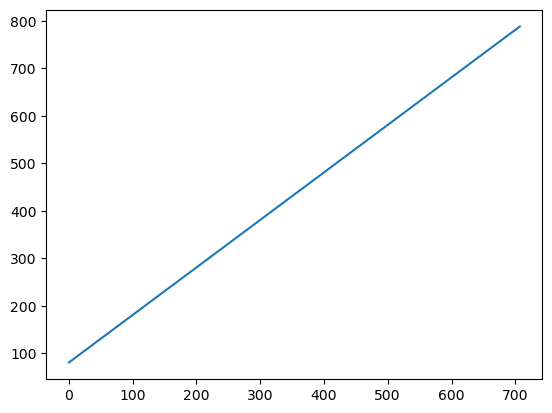

In [12]:
plt.plot(x/1e3,z/1e3)

/tmp/ipykernel_133484/4149780230.py:3: DeprecationWarning: scipy.misc.derivative is deprecated in SciPy v1.10.0; and will be completely removed in SciPy v1.12.0. You may consider using findiff: https://github.com/maroba/findiff or numdifftools: https://github.com/pbrod/numdifftools
  dp_zdt = lambda z, n: 0.5 * derivative(lambda z: n(z)**2, z, dx=1, n=1, order=3)


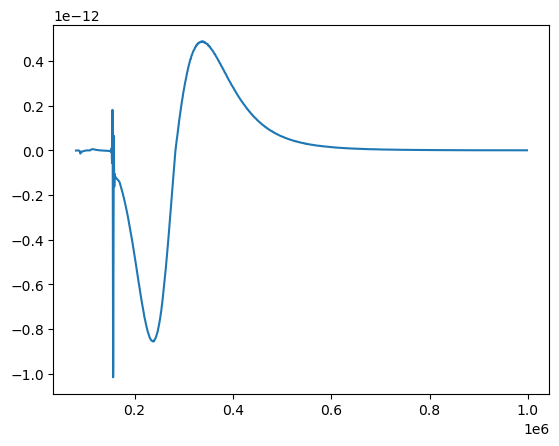

In [13]:
z_ = np.linspace(z_night[1], z_night[-2], 4096)
plt.plot(z_, dp_zdt(z_,interpol_n_night))